In [186]:
import itertools
import math
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import pickle as pkl
import os
import numpy as np
from tint.datasets import HMM
from experiments.mimic3.mortality.data import Mimic3

In [160]:
# Define identical HMM definition as in the experiment
# This will load the generated HMM data instead of re-generating the files (which take a long time)
hmm = HMM(n_folds=5, fold=0, seed=42)

In [161]:
# HMM - Get train and test input and output (x and y)
hmm_test_data = hmm.preprocess("test")
hmm_test_x, hmm_test_y = hmm_test_data["x"].numpy(), hmm_test_data["y"].numpy()
hmm_true_saliency = hmm.true_saliency(split="test").numpy()

In [162]:
# Get test predictions from the classifier (y_hat)
with open(
    os.path.join(hmm.data_dir, "classifier_predictions_test.npz"), "rb"
) as fp:
    y_hat = pkl.load(file=fp).detach().numpy()
    
y_hat.shape

(200, 200)

In [163]:
# MIMIC3 - Get train and test input and output (x and y)
mimic3 = Mimic3(n_folds=5, fold=0, seed=42)

_ = mimic3.preprocess("train")
mimic3_test_data = mimic3.preprocess("test")
mimic3_test_x, mimic3_test_y = mimic3_test_data["x"].numpy(), mimic3_test_data["y"].numpy()

/Users/adamdivak/Documents/Study/Fairness/Assignment/time_interpret/experiments/mimic3/data/mimic3


In [164]:
# Get saved explanations by all explainers
with open(
    os.path.join(hmm.data_dir, "hmm_saliency.npz"), "rb"
) as fp:
    hmm_saliency = pkl.load(file=fp)
    # try:
    #     hmm_saliency = {k: v.detach().numpy() for k, v in hmm_saliency.items()}
    # except Exception:
    #     pass
with open(
    os.path.join("mimic3/mortality/results/mimic3_saliency.npz"), "rb"
) as fp:
    mimic3_saliency = pkl.load(file=fp)

# Flip deletion extremal masks, so they have the same meaning as the preservation ones
# No longer needed, we have added this to the code itself
# if "extremal_mask_deletion" in hmm_saliency:
#     hmm_saliency["extremal_mask_deletion"] = 1 - hmm_saliency["extremal_mask_deletion"]
# if "extremal_mask_deletion" in mimic3_saliency:
#     mimic3_saliency["extremal_mask_deletion"] = 1 - mimic3_saliency["extremal_mask_deletion"]

print(hmm_saliency.keys())
print(hmm_saliency[list(hmm_saliency.keys())[0]].shape)
print(mimic3_saliency.keys())
print(mimic3_saliency[list(mimic3_saliency.keys())[0]].shape)

dict_keys(['extremal_mask_deletion', 'deep_lift', 'dyna_mask', 'gradient_shap', 'integrated_gradients', 'lime', 'augmented_occlusion', 'occlusion', 'retain', 'extremal_mask_preservation'])
(200, 200, 3)
dict_keys(['extremal_mask_deletion'])
(1776, 48, 31)


In [165]:
# Load perturbed signals, saved in a separate file
with open(
    os.path.join(hmm.data_dir, "x_test_perturbed_signals.npz"), "rb"
) as fp:
    x_perturbed_signals_hmm = pkl.load(file=fp)
with open(
    os.path.join("mimic3/mortality/results/mimic3_perturbed_signals.npz"), "rb"
) as fp:
    x_perturbed_signals_mimic = pkl.load(file=fp)
    
print(x_perturbed_signals_hmm.keys())
print(x_perturbed_signals_mimic.keys())

dict_keys(['extremal_mask_preservation', 'extremal_mask_deletion'])
dict_keys(['extremal_mask_deletion'])


# True vs explanation saliency

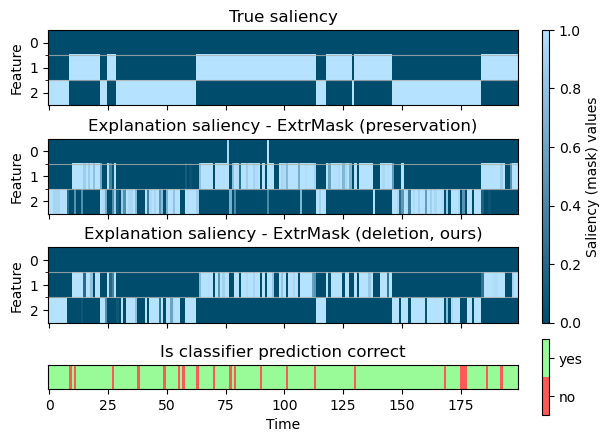

In [166]:
# Helper function to create a single subplot
def plot_saliency_subplot(ax, saliency, label, cmap, num_features=3):
    saliency_img = ax.imshow(saliency, interpolation='nearest', cmap=cmap, aspect="auto")
    feature_values = np.arange(num_features)
    ax.label_outer()
    
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(feature_values)
    ax.set_yticks(feature_values[:-1] + 0.5, minor=True)
    ax.grid(which='minor', alpha=0.8)
    ax.grid(which='major', alpha=0.0)
    ax.grid()
    ax.set_ylabel("Feature")
    ax.set_title(label)
    
    return saliency_img

def plot_saliency(explanation_methods, sample, save_fn=None):

    # Light-dark blue colormap for the saliency maps
    colors = ["#004c6d", "#b5e2ff"]
    blues = LinearSegmentedColormap.from_list("blues", colors, N=200)
    
    # Red-green colormap for the accurate/inaccurate classifier plot
    colors = ["xkcd:grapefruit", "palegreen"]
    red_green_cmap = LinearSegmentedColormap.from_list("red_green", colors, N=2)
    
    subplot_rows = len(explanation_methods) + 2
    fig, axs = plt.subplots(subplot_rows, 1, figsize=(6, (3 + len(explanation_methods))), layout='compressed')
    # fig.suptitle(f"Saliency for sample {sample}")
    
    # Plot true saliency
    img_true_saliency = plot_saliency_subplot(ax=axs[0], saliency=hmm_true_saliency[sample, :, :].T, label="True saliency", cmap=blues)
    
    # Plot explained saliency per method
    for (method, method_name), ax in zip(explanation_methods.items(), axs[1:-1]):
        if method in hmm_saliency:
            saliency = hmm_saliency[method]
            plot_saliency_subplot(ax=ax, saliency=saliency[sample, :, :].T, label=method_name, cmap=blues)
    
    # Plot classifier accuracy
    classifier_prediction_correct = (hmm_test_y[sample] == y_hat[sample]).astype(int).reshape(1, -1)
    img_classifier_accuracy = axs[-1].imshow(classifier_prediction_correct, cmap=red_green_cmap, aspect=100)
    
    ratio = 10/200.0
    xleft, xright = axs[-1].get_xlim()
    ybottom, ytop = axs[-1].get_ylim()
    axs[-1].set_aspect(abs((xright - xleft) / (ybottom - ytop)) * ratio)

    axs[-1].set_yticks([])
    axs[-1].set_title("Is classifier prediction correct")
    axs[-1].set_xlabel("Time")
    
    # Add colorbars to the correct places
    plt.colorbar(img_true_saliency, ax=axs[:-1], fraction=0.05, aspect=40, label="Saliency (mask) values")
    plt.colorbar(img_classifier_accuracy, ax=axs[-1], fraction=0.05, aspect=10, ticks=[0.25, 0.75], format=mpl.ticker.FixedFormatter(["no", "yes"]))
    
    if save_fn:
        save_dir = os.path.dirname(save_fn)
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(save_fn)
        
    return fig

In [ ]:
# HMM sample to plot
sample = 0

# Explanation methods shown
explanation_methods = {
    "extremal_mask_preservation": "Explanation saliency - ExtrMask (preservation)", 
    "extremal_mask_deletion": "Explanation saliency - ExtrMask (deletion, ours)",
}

_ = plot_saliency(explanation_methods=explanation_methods, sample=sample, save_fn=f"figures/true_explained_saliency.svg")

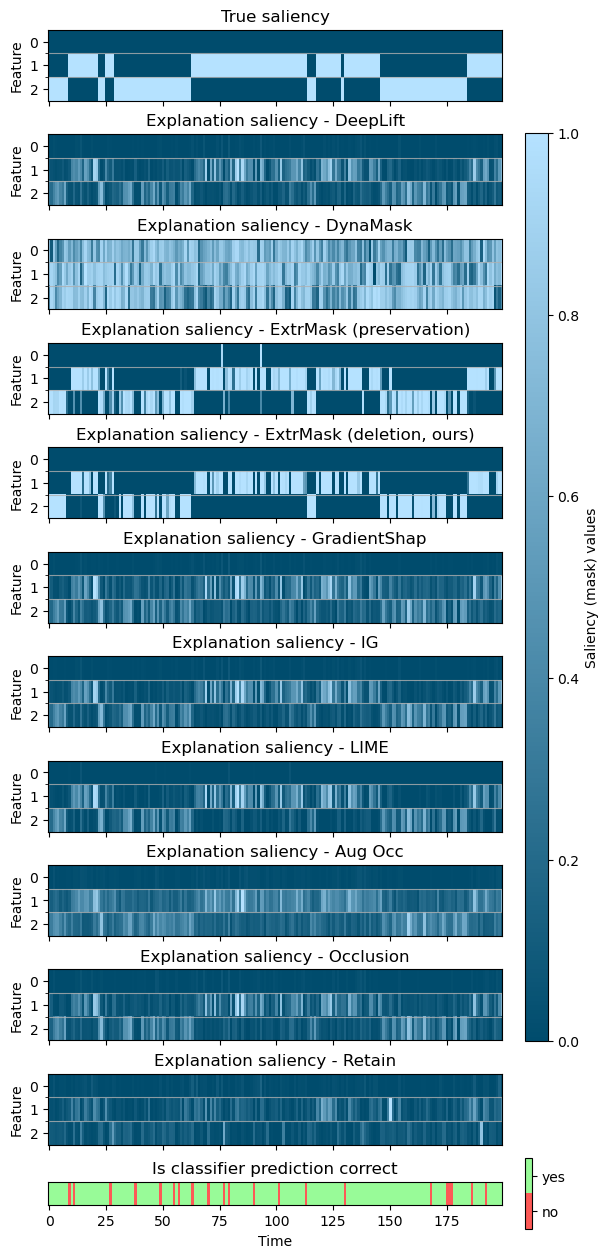

In [167]:
# Explanation methods shown
explanation_methods_all = {
    "deep_lift": "Explanation saliency - DeepLift",
    "dyna_mask": "Explanation saliency - DynaMask",
    "extremal_mask_preservation": "Explanation saliency - ExtrMask (preservation)", 
    "extremal_mask_deletion": "Explanation saliency - ExtrMask (deletion, ours)",
    # "fit": "Explanation saliency - Fit", # did not run correctly during generation
    "gradient_shap": "Explanation saliency - GradientShap",
    "integrated_gradients": "Explanation saliency - IG",
    "lime": "Explanation saliency - LIME",
    "augmented_occlusion": "Explanation saliency - Aug Occ",
    "occlusion": "Explanation saliency - Occlusion",
    "retain": "Explanation saliency - Retain",
}

_ = plot_saliency(explanation_methods=explanation_methods_all, sample=sample, save_fn=f"figures/true_explained_saliency_all_methods.svg")

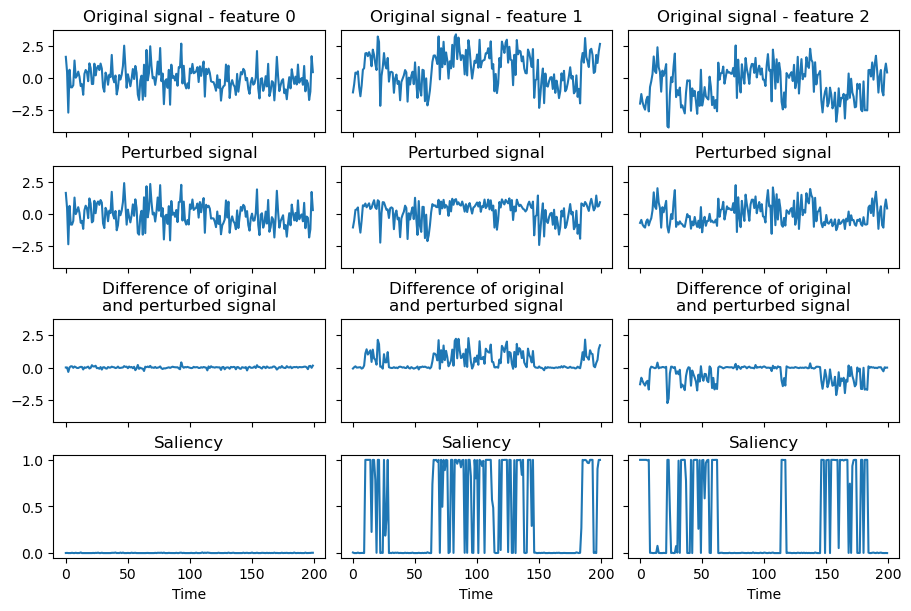

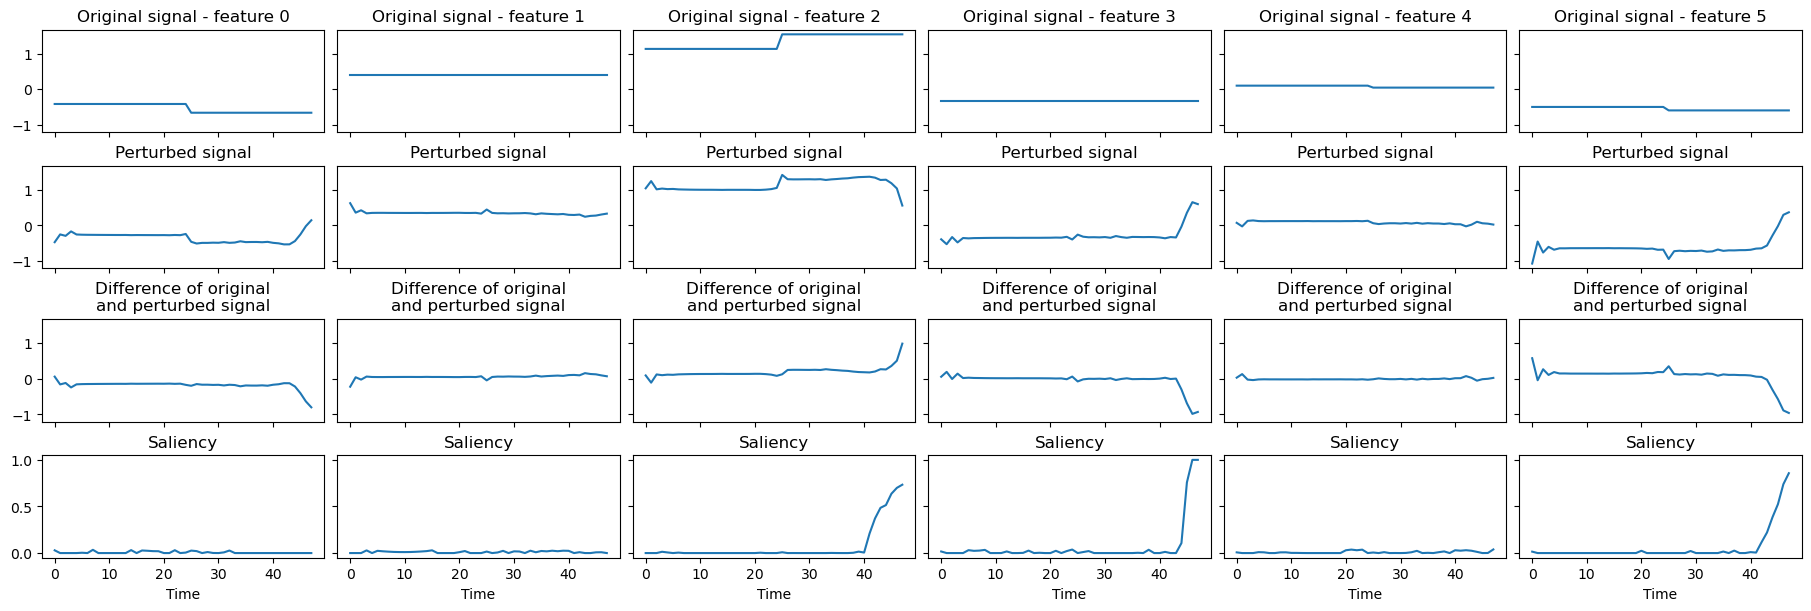

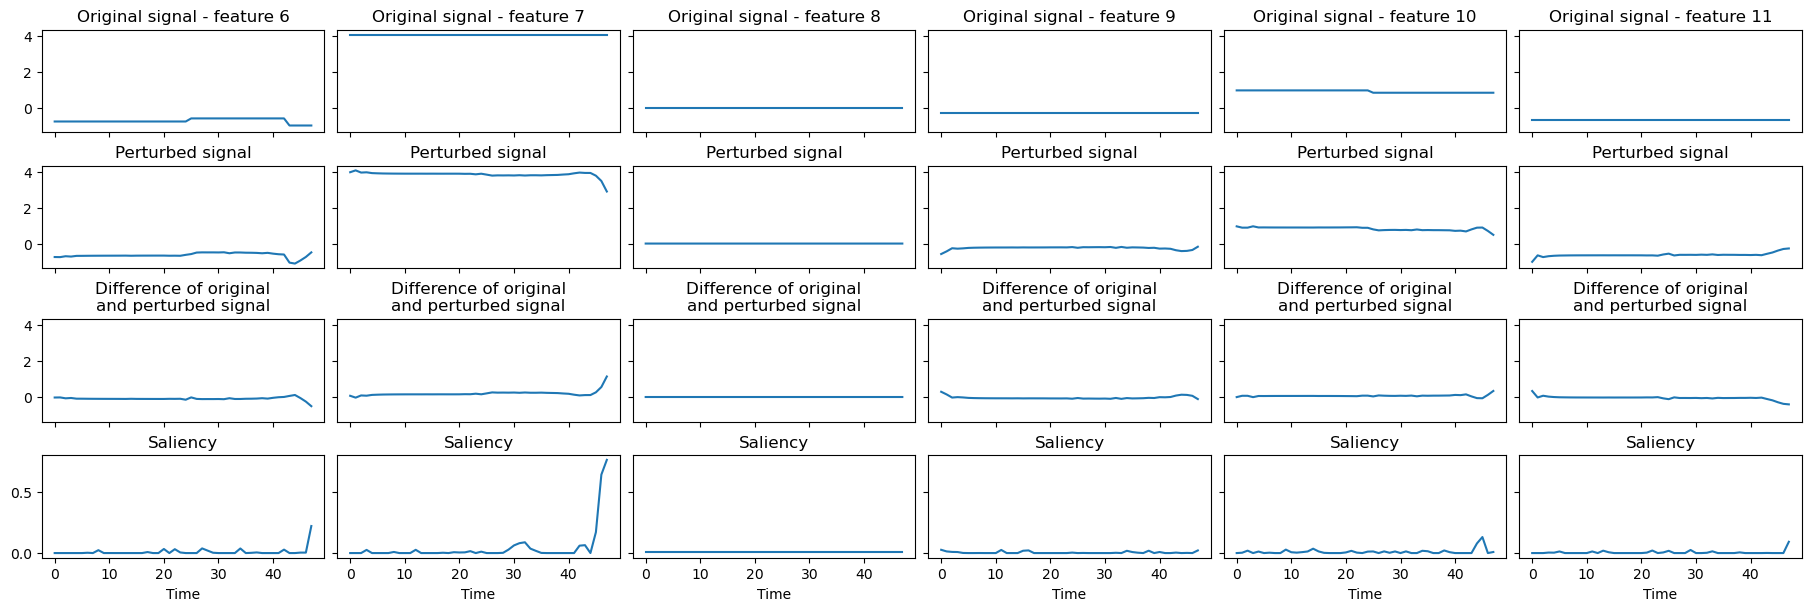

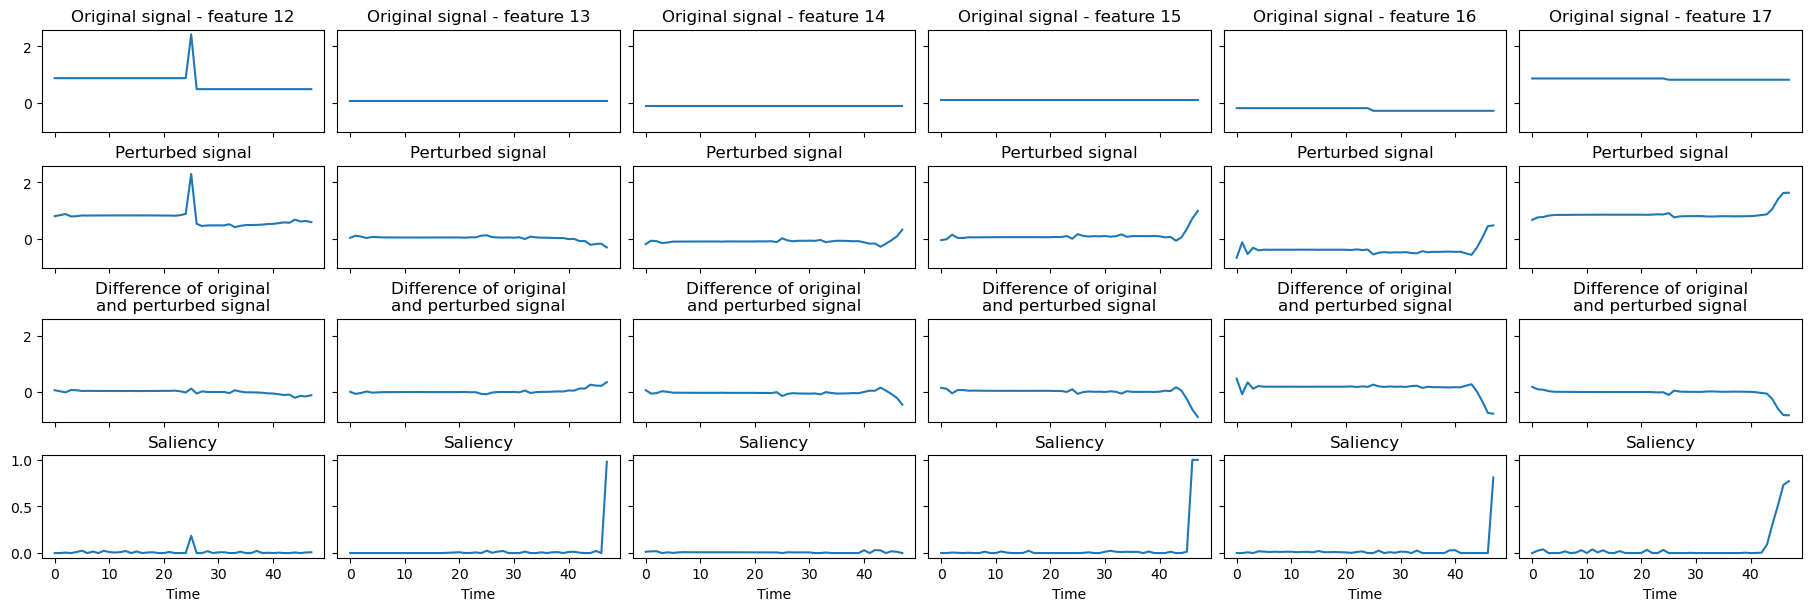

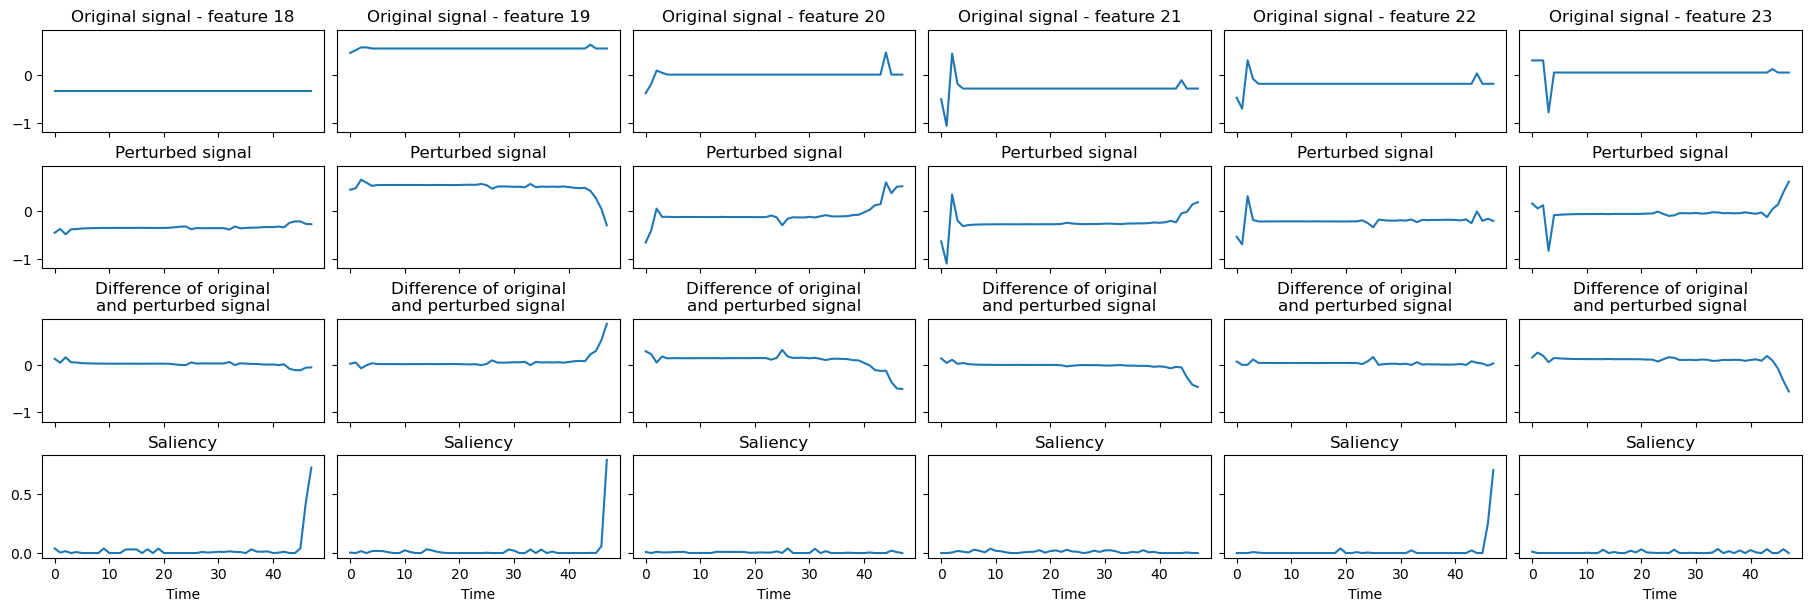

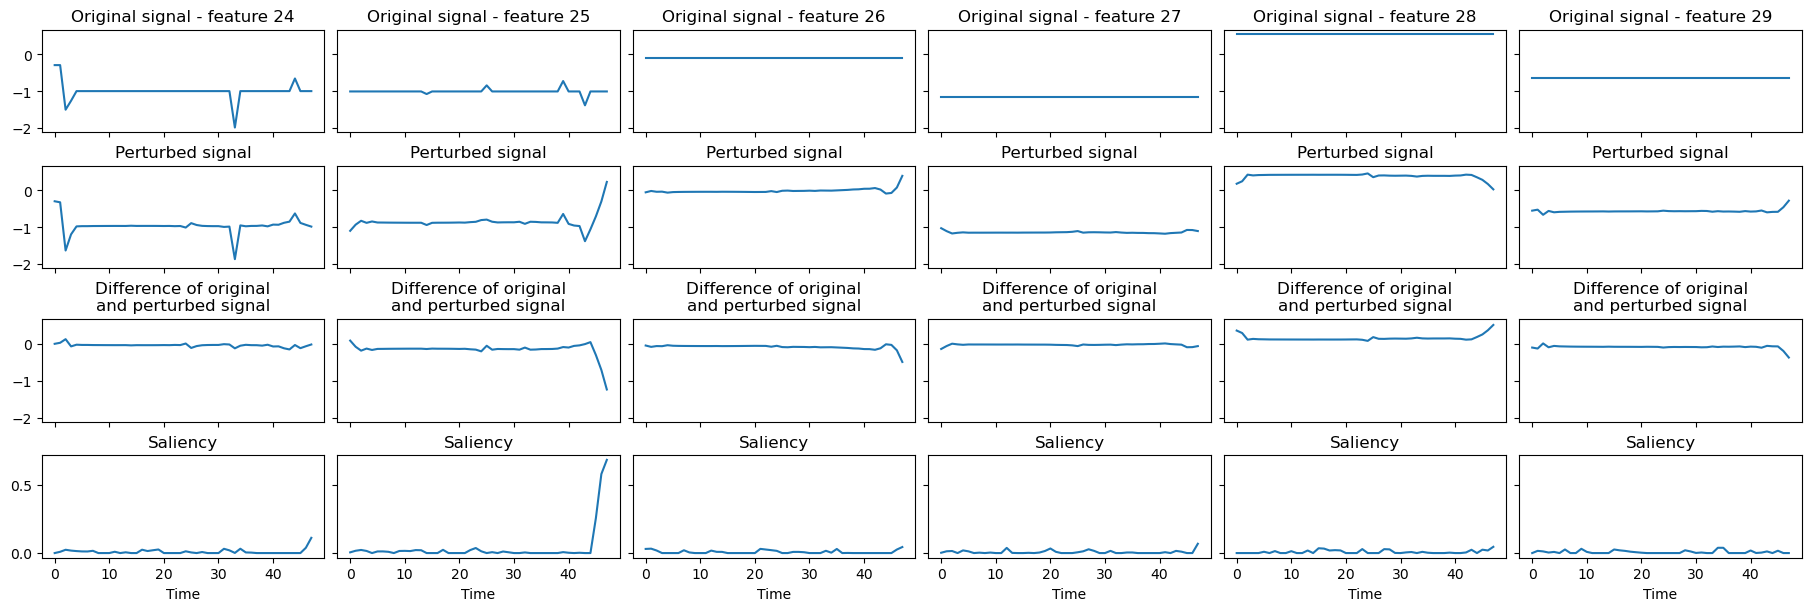

In [201]:
sample = 0

experiments = ["hmm", "mimic"]
explanation_methods = {
    # "extremal_mask_preservation": "ExtrMask (preservation)", 
    "extremal_mask_deletion": "ExtrMask (deletion, ours)"
}

# itertools.batched is only available in Python 3.12
def batched(iterable, n):
    # batched('ABCDEFG', 3) --> ABC DEF G
    if n < 1:
        raise ValueError('n must be at least one')
    it = iter(iterable)
    while batch := tuple(itertools.islice(it, n)):
        yield batch

def plot_perturbation(input_signals, perturbed_signal, saliency, num_features, method, method_name, max_features_per_row=6):
    all_feature_ids = range(0, num_features)
    figs = []
    for group_id, feature_ids in enumerate(list(batched(all_feature_ids, max_features_per_row))):
        base_ax = None
        base_mask_ax = None
        
        num_features = len(feature_ids)
        fig, axs = plt.subplots(4, num_features, figsize=(3 * num_features, 6), layout='compressed')
        
        for feature_id, ax_group in zip(feature_ids, axs.T):
            add_y_axis = feature_id == 0
            ax_x, ax_perturbed_signal, ax_perturbed_signal_diff, ax_saliency = ax_group[0], ax_group[1], ax_group[2], ax_group[3]
            if base_ax is None:
                base_ax = ax_x
            if base_mask_ax is None:
                base_mask_ax = ax_saliency
    
            ax_x.plot(input_signals[sample, :, feature_id], label=f"x{feature_id}")
            ax_x.sharey(base_ax)
            ax_x.set_title(f"Original signal - feature {feature_id}")
            ax_x.set_xlabel(f"Time")
            ax_x.label_outer()
    
            ax_perturbed_signal.plot(perturbed_signal[sample, :, feature_id])
            ax_perturbed_signal.set_title(f"Perturbed signal")
            ax_perturbed_signal.sharey(base_ax)
            ax_perturbed_signal.set_xlabel(f"Time")
            ax_perturbed_signal.label_outer() # set labels on the first plot only
            
            ax_perturbed_signal_diff.plot(input_signals[sample, :, feature_id] - perturbed_signal[sample, :, feature_id])
            ax_perturbed_signal_diff.set_title(f"Difference of original\nand perturbed signal")
            ax_perturbed_signal_diff.sharey(base_ax)
            ax_perturbed_signal_diff.set_xlabel(f"Time")
            ax_perturbed_signal_diff.label_outer() # set labels on the first plot only
            
            ax_saliency.plot(saliency[sample, :, feature_id])
            ax_saliency.set_title(f"Saliency")
            ax_saliency.sharey(base_mask_ax)
            ax_saliency.set_xlabel(f"Time")
            ax_saliency.label_outer()
        
        # fig.suptitle(f"{experiment} {method_name} {sample} input signals, masks and perturbed signals")
        os.makedirs("figures", exist_ok=True)
        plt.savefig(f"figures/{experiment}_{method}_{sample}_inputs_masks_perturbations_{group_id}.svg")
        
        figs.append(fig)
    return figs
    
for experiment in experiments:
    if experiment == "hmm":
        input_signals = hmm_test_x
        perturbed_signals = x_perturbed_signals_hmm
        saliencies = hmm_saliency
        num_features = 3
    elif experiment == "mimic":
        input_signals = mimic3_test_x
        perturbed_signals = x_perturbed_signals_mimic
        saliencies = mimic3_saliency
        num_features = 30
    else:
        raise ValueError(f"Unrecognized experiment {experiment}")
    
    for method, method_name in explanation_methods.items():
        saliency = saliencies[method]
        perturbed_signal = perturbed_signals[method]
        
        figs = plot_perturbation(input_signals, perturbed_signal, saliency, num_features, method, method_name)
        
        plt.show()